In [1]:
import pandas as pd
import pandas_profiling as pp
import matplotlib as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3)
%matplotlib inline

In [2]:
import datetime

In [3]:
date_parser = lambda ts: datetime.strptime(ts, "%y-%m-%dT%H:%M:%SZ")
df = pd.read_csv('./pricing/aviasales_data_t.csv')
df['requested_at'] = pd.to_datetime(df['requested_at'], format="%y-%m-%dT%H:%M:%SZ", errors="coerce")
df['departure_at'] = pd.to_datetime(df['departure_at'], format="%Y-%m-%dT%H:%M:%SZ", errors="coerce")
df['expires_at'] = pd.to_datetime(df['expires_at'], format="%Y-%m-%dT%H:%M:%SZ", errors="coerce")
df['price'] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna()
df

,origin,destination,departure_at,airline,flight_number,price,expires_at,requested_at
0,MOW,LED,2021-03-06 18:45:00,DP,205,3568.0,2021-03-06 13:24:28,2021-03-06 10:28:54
1,MOW,LED,2021-03-07 04:20:00,U6,9631,2438.0,2021-03-07 04:20:00,2021-03-06 10:28:54
2,MOW,LED,2021-03-08 03:45:00,DP,201,2411.0,2021-03-08 03:45:00,2021-03-06 10:28:54
3,MOW,LED,2021-03-09 05:10:00,DP,207,2618.0,2021-03-09 05:10:00,2021-03-06 10:28:54
4,MOW,LED,2021-03-10 04:30:00,DP,209,2468.0,2021-03-09 06:15:06,2021-03-06 10:28:54
...,...,...,...,...,...,...,...,...
318658,SVX,VVO,2021-04-29 10:30:00,S7,5018,29138.0,2021-04-21 12:37:03,2021-04-20 06:30:09
318659,SVX,VVO,2021-04-30 10:30:00,S7,5018,29138.0,2021-04-21 17:50:06,2021-04-20 06:30:09
318660,SVX,YKS,2021-04-21 10:30:00,S7,5018,27406.0,2021-04-21 09:48:55,2021-04-20 06:30:09
318661,SVX,YKS,2021-04-25 10:30:00,S7,5018,27406.0,2021-04-21 05:53:31,2021-04-20 06:30:09


In [4]:
# Duplicates? What we consider to be one of them?
# -- Entries with the same 'departure_at', 'expires_at', 'flight_number', 'price' -- Middle priority, easy to fix
df = df.drop_duplicates(subset=['departure_at', 'expires_at', 'airline', 'flight_number', 'price'], keep='first')

departure_at
2021-03-07     8979.000000
2021-03-08     9538.400000
2021-03-09    10269.888889
2021-03-10     9808.571429
2021-03-11     8863.000000
2021-03-12     8717.222222
2021-03-13     9736.142857
2021-03-14     8686.235294
2021-03-15     8823.736842
2021-03-16     8705.409091
2021-03-17     8732.454545
2021-03-18     9997.952381
2021-03-19    14125.782609
2021-03-20    12944.781250
2021-03-21    12908.347826
2021-03-22    11468.771429
2021-03-23     9401.240000
2021-03-24     9507.333333
2021-03-25     9795.750000
2021-03-26    10927.375000
2021-03-27     8567.200000
2021-03-28     8713.547619
2021-03-29     9093.279070
2021-03-30     8514.382979
2021-03-31     8568.507937
2021-04-01     9012.310345
2021-04-02     8714.962963
2021-04-03     8665.548387
2021-04-04     8953.212121
2021-04-05     8367.966667
2021-04-06     8236.238095
2021-04-07     8324.272727
2021-04-08     8840.218750
2021-04-09     8714.277778
2021-04-10     8355.500000
2021-04-11     8365.836735
2021-04-12     

TypeError: 'module' object is not callable

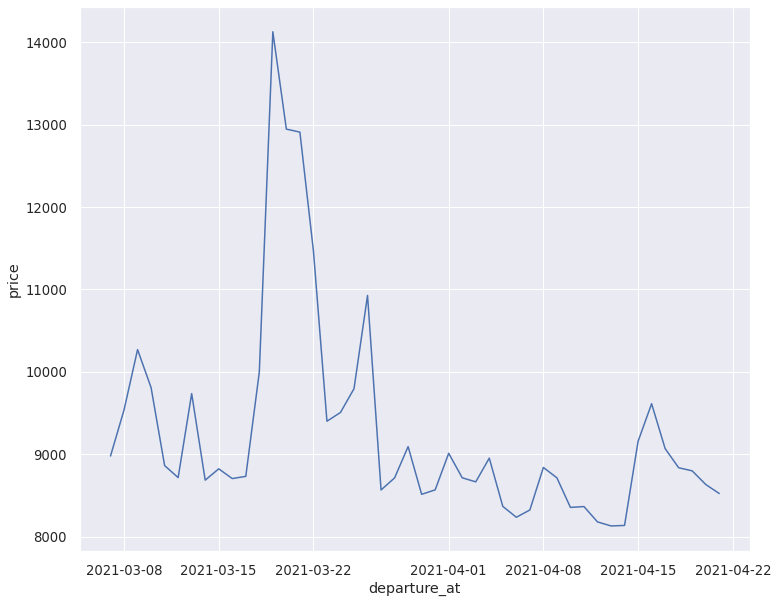

In [5]:
sns.set(context='notebook', font_scale=1.2, rc={'figure.figsize':(12,10)})
#  Avg prices on each day
kzn_soc = df[(df["origin"] == "KZN") & (df["destination"] == "AER") & (df["departure_at"] <= datetime.datetime.now()) & (df["departure_at"] >= "2021-03-07")]
#  2021-03-06 is out

# kzn_soc['day'] = kzn_soc['departure_at'].date
kzn_soc_day = kzn_soc.resample('D', on='departure_at')['price'].mean()
# kzn_soc_day = pd.DataFrame(kzn_soc_day)
# kzn_soc_day['departure_at'] = kzn_soc_day.index
display(kzn_soc_day)
kl = sns.lineplot(data=kzn_soc_day)
kl.set(xlim=(datetime.date(datetime(2021,3,7)), datetime.now()), title="Min prices for KZN-AER in March")

In [ ]:
# Avg prices by weekday
kzn_soc_wd = kzn_soc.groupby(kzn_soc['departure_at'].dt.weekday)['price'].mean()
display(kzn_soc_wd)
kwl = sns.lineplot(data=kzn_soc_wd)
kwl.set(title="Average prices for KZN-AER by w-day")

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

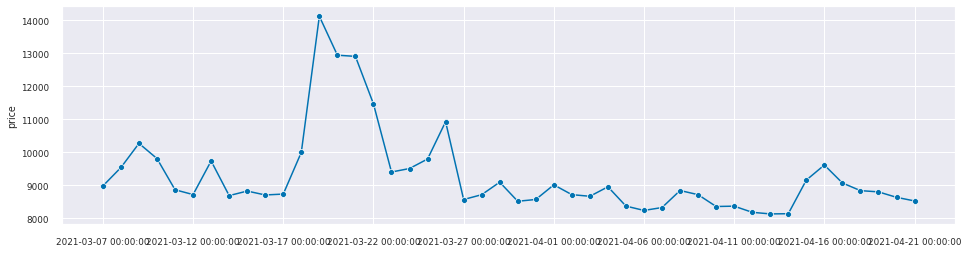

In [6]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import ARIMA, AutoARIMA

sns.set(font_scale=.8)
y = kzn_soc_day
plot_series(y)

34 12


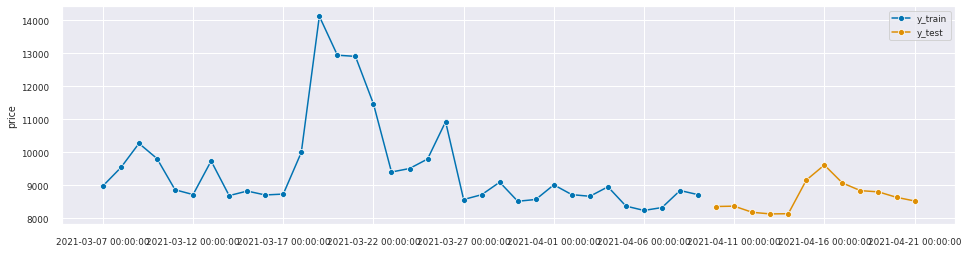

In [7]:
y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

0.04740513945687943

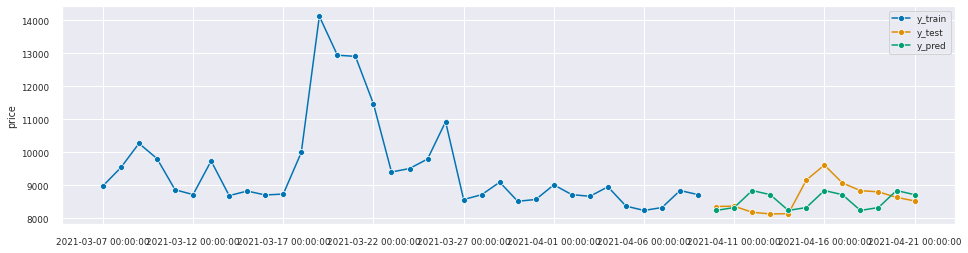

In [8]:
# Naive Forecaster
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


0.04549919289642176

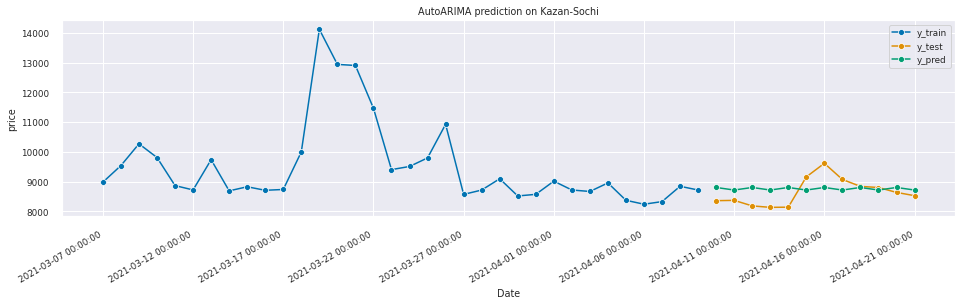

In [9]:
forecaster = AutoARIMA(sp=2) # 2 is best for this case
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.set(title="AutoARIMA prediction on Kazan-Sochi", xlabel="Date")
fig.autofmt_xdate()
smape_loss(y_test, y_pred)

Тренд установился правильно, но присутствует сдвиг вверх

Let's try different destinations, different models, different statistics

По времени до вылета

In [10]:
kzn_soc

,origin,destination,departure_at,airline,flight_number,price,expires_at,requested_at
2187,KZN,AER,2021-03-07 14:00:00,S7,1054,8787.0,2021-03-07 14:00:00,2021-03-06 10:28:54
2188,KZN,AER,2021-03-08 09:25:00,DP,338,10298.0,2021-03-08 09:25:00,2021-03-06 10:28:54
2189,KZN,AER,2021-03-09 18:10:00,N4,137,10201.0,2021-03-08 06:06:18,2021-03-06 10:28:54
2190,KZN,AER,2021-03-10 17:20:00,DP,284,9358.0,2021-03-08 09:24:21,2021-03-06 10:28:54
2191,KZN,AER,2021-03-11 11:45:00,7R,215,8656.0,2021-03-07 10:42:06,2021-03-06 10:28:54
...,...,...,...,...,...,...,...,...
316362,KZN,AER,2021-04-20 01:55:00,S7,1060,9897.0,2021-04-20 01:55:00,2021-04-19 18:30:09
316363,KZN,AER,2021-04-21 13:55:00,S7,1054,9897.0,2021-04-21 13:55:00,2021-04-19 18:30:09
317206,KZN,AER,2021-04-21 01:55:00,S7,1060,8692.0,2021-04-21 01:55:00,2021-04-20 00:30:07
318032,KZN,AER,2021-04-20 13:55:00,S7,1054,9000.0,2021-04-20 13:55:00,2021-04-20 06:30:09


In [11]:
def predict_prices(orgn, dest):
    #  Avg prices on each day, 2021-03-06 is out
    orgn_dest = df[(df["origin"] == orgn) & (df["destination"] == dest) & (df["departure_at"] <= datetime.datetime.now()) & (df["departure_at"] >= "2021-03-07")]
    # orgn_dest = orgn_dest.dropna()
    orgn_dest_day = orgn_dest.resample('D', on='departure_at')['price'].mean() 
    
    if orgn_dest_day.empty:
        return ("nan", orgn, dest)
    y = orgn_dest_day
    y_train, y_test = temporal_train_test_split(y)
    
    forecaster = AutoARIMA(sp=2, suppress_warnings=True)
    # forecaster = NaiveForecaster(strategy="last")
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    return (smape_loss(y_test, y_pred), orgn, dest)

[(0.042877497065490384, 'MOW', 'LED'),
 (0.04942983808289216, 'MOW', 'SVX'),
 (0.05222852787157816, 'MOW', 'KZN'),
 (0.08701019513618051, 'MOW', 'CEK'),
 (0.1177963397085367, 'MOW', 'AER')]

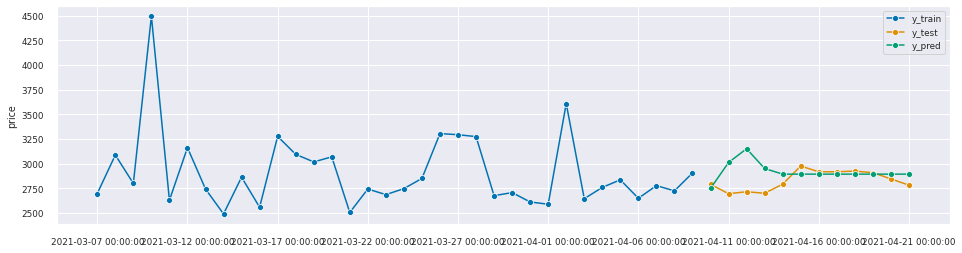

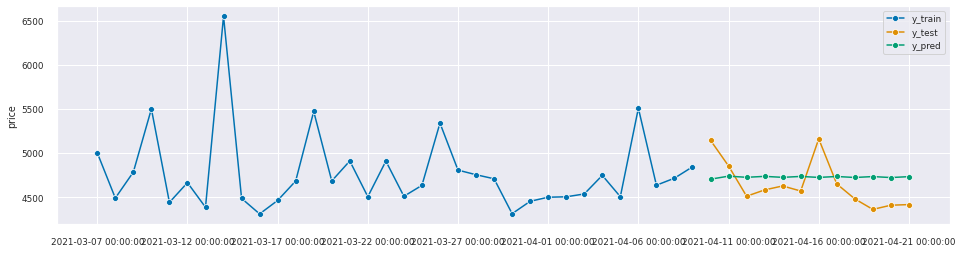

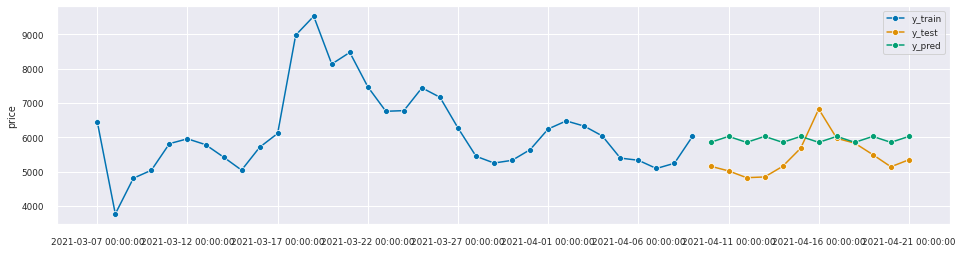

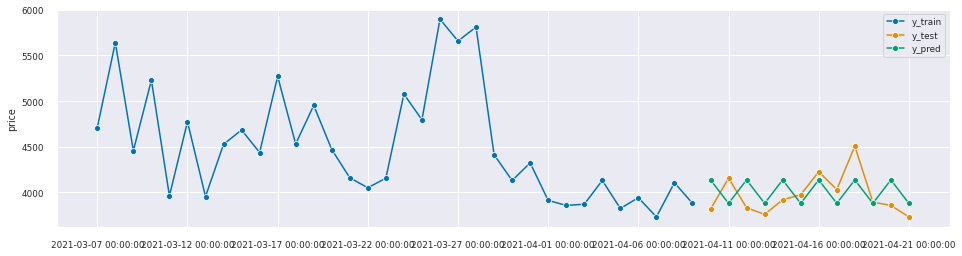

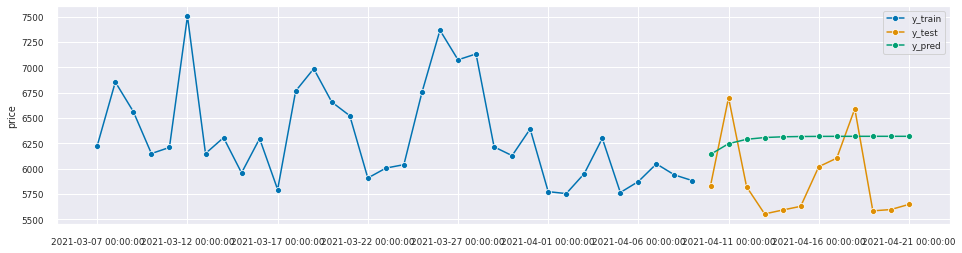

In [12]:
smapes = []
i = "MOW"
#for i in set(df["origin"]):
df_m = df[df["origin"] == "MOW"]
for j in ["LED", "KZN", "AER", "SVX", "CEK"]:
    smapes.append(predict_prices(i, j))
# smapes.append(predict_prices("MOW", "LED"))
clean_smapes = [i for i in smapes if str(i[0]) != "nan"]
clean_smapes.sort()
clean_smapes

Сделать на основе функции выше новую, предсказывающую цены по направлению в зависимости от дней до вылета.

In [13]:
def predict_queried_prices_for(orgn, dest, current_date, flight_date, n_days):
    
    orgn_dest = df[(df["origin"] == orgn) & (df["destination"] == dest) & (df["departure_at"] <= flight_date) 
                   & (df["requested_at"] >= df["departure_at"] - datetime.timedelta(days=n_days + 1))
                   & (df["requested_at"] <= df["departure_at"] - datetime.timedelta(days=n_days))] 
    # display(orgn_dest)
    
    orgn_dest_day_min = orgn_dest.resample('D', on='requested_at')['price'].min()
  
    orgn_dest_day_min = orgn_dest_day_min.fillna(orgn_dest_day_min.mean())  # not very smart
    
    # display(orgn_dest_day_min)
    
    y = orgn_dest_day_min
    y_train, y_test = temporal_train_test_split(y) # make test smaller?
    
    forecaster = AutoARIMA()
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    # plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    return round(y_pred[-1])

In [14]:
def predict_queried_prices(orgn, dest, current_date, flight_date):
    days = []
    predictions = []
    delta = flight_date - current_date
    for i in range(delta.days + 1):
        days.append((flight_date - datetime.timedelta(days=i)).strftime("%Y-%m-%d"))
        predictions.append(predict_queried_prices_for(orgn, dest, current_date, flight_date, i))
    return days, predictions

In [15]:
predict_queried_prices("MOW", "KZN", datetime.datetime(2021,4,3), datetime.datetime(2021,4,10))

/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/stats

(['2021-04-10',
  '2021-04-09',
  '2021-04-08',
  '2021-04-07',
  '2021-04-06',
  '2021-04-05',
  '2021-04-04',
  '2021-04-03'],
 [5267, 4565, 4378, 4347, 4297, 4180, 4451, 4483])

In [16]:
# Flight_date has to be before today's
def show_real_prices(orgn, dest, current_date, flight_date, delta_days=7):
    
    orgn_dest = df[(df["origin"] == orgn) & (df["destination"] == dest) & (df["departure_at"] <= flight_date + datetime.timedelta(days=1))
                   & (df["departure_at"] >= flight_date)]
    # display(orgn_dest)
    
    days = []
    prices = []
    for i in range(delta_days + 1):
        orgn_dest_day = orgn_dest[(orgn_dest["requested_at"] >= orgn_dest["departure_at"] - datetime.timedelta(days=i + 1))
                           & (orgn_dest["requested_at"] <= orgn_dest["departure_at"] - datetime.timedelta(days=i))]
        if orgn_dest_day.empty:
            orgn_dest_day = orgn_dest[(orgn_dest["expires_at"] >= orgn_dest["departure_at"] - datetime.timedelta(days=i + 1))
                               & (orgn_dest["expires_at"] <= orgn_dest["departure_at"] - datetime.timedelta(days=i))]
        
        prices.append(round(orgn_dest_day["price"].min()))
        days.append((flight_date - datetime.timedelta(days=i)).strftime("%Y-%m-%d"))
        # display(orgn_dest_day)
    return days, prices

In [17]:
show_real_prices("MOW", "KZN", datetime.datetime(2021,4,3), datetime.datetime(2021,4,10))

(['2021-04-10',
  '2021-04-09',
  '2021-04-08',
  '2021-04-07',
  '2021-04-06',
  '2021-04-05',
  '2021-04-04',
  '2021-04-03'],
 [5698, 4848, 4598, 4848, 4848, 4498, 4498, 4498])

In [19]:
def compare_prediction_results(orgn, dest, current_date, flight_date):
    print("Predictions:", predict_queried_prices(orgn, dest, current_date, flight_date))
    print("Real prices:", show_real_prices("MOW", "KZN", current_date, flight_date))
    # Count metrics

In [20]:
compare_prediction_results("MOW", "KZN", datetime.datetime(2021,4,3), datetime.datetime(2021,4,10))

/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/vladimir/miniconda3/envs/ml/lib/python3.7/site-packages/stats

Predictions: (['2021-04-10', '2021-04-09', '2021-04-08', '2021-04-07', '2021-04-06', '2021-04-05', '2021-04-04', '2021-04-03'], [5267, 4565, 4378, 4347, 4297, 4180, 4451, 4483])
Real prices: (['2021-04-10', '2021-04-09', '2021-04-08', '2021-04-07', '2021-04-06', '2021-04-05', '2021-04-04', '2021-04-03'], [5698, 4848, 4598, 4848, 4848, 4498, 4498, 4498])
